In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.synthetic_generators import *
from generators.ESN import ESNGenerator
from sigkernel_.loss import compute_mmd_loss

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

# Define ESN
Let $ A \in \mathbb{R}^{N \times N} $, $ C \in \mathbb{R}^{N \times U} $, $ W \in \mathbb{R}^{M \times N} $.  
Let $x_{b,t} \in \mathbb{R}^{N} $, $ \xi_{b,t} \in \mathbb{R}^{U} $, $ \eta_{b,t} \in \mathbb{R}^{M} $, and optionally $ \mathrm{tilt}_{b,t} \in \mathbb{R}^{M} $.  
Let $ \phi(\cdot) $ be the activation function.

State update:
$$
x_{b,t+1} = \phi\!\left( A x_{b,t}  + C\xi_{b,t}\right)
$$

Output before tilt:
$$
z_{b,t} = W x_{b,t+1} + \eta_{b,t}
$$

Optional tilt:
$$
z_{b,t} = z_{b,t} + \mathrm{tilt}_{b,t}
$$

Storage:
$$
Z_{b,t} = z_{b,t}, \qquad X_{\text{hist}, b,t} = x_{b,t+1}
$$


In [ ]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 50  # number of samples
d = 1   # dimension of time series


h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension (\xi : randomness), output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix
activation = "tanh"

# Define data generator and esn
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05, activation=activation)

## Effect of noise dimension `m` in the ESN

`m` controls how many independent random directions drive the reservoir at each time step. It sets the **stochastic dimension** of the generator.

### Small `m` (e.g. 1–5)
- Noise enters through a low-dimensional bottleneck  
- Dynamics mostly deterministic + weak stochastic forcing  
- Consequences:
  - Strong temporal correlations
  - Low instantaneous randomness
  - Paths look smooth and history-driven  
- Good when:
  - Target is close to low-dimensional SDE / ARMA
  - You want structure more than raw randomness  
- MMD view:
  - Kernel focuses on dynamics/memory
  - Risk: under-dispersed samples (too little variability)

### Moderate `m` (e.g. 10–50) **(usually best)**
- Noise injects multiple independent directions each step  
- Reservoir can mix noise nonlinearly and create rich dynamics  
- Consequences:
  - Enough randomness to match distributional spread
  - Still preserves temporal structure  
- MMD view:
  - Easier to match both marginals and temporal dependence
  - Healthier gradients and better optimization

### Large `m` (≈ `h` or bigger)
- Noise dominates state update, memory weakens  
- Reservoir behaves more like a feedforward noise filter  
- Consequences:
  - Temporal structure degrades
  - Samples become too i.i.d.-like in time
  - May match marginals but miss dynamics  
- MMD view:
  - Static kernels may be fooled
  - Sequential kernels still detect missing dynamics
  - Training can become noisy/unstable



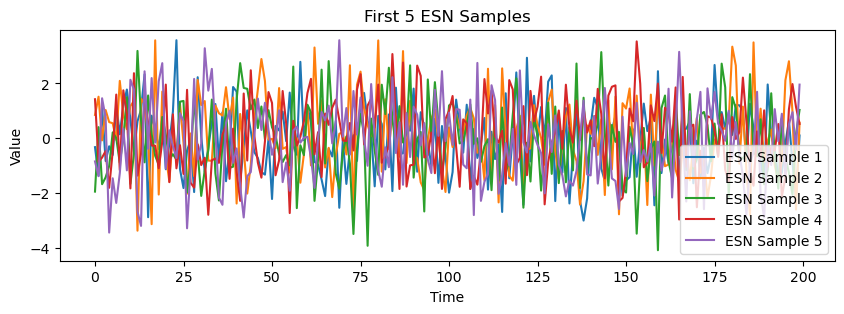

In [4]:
Z_esn = esn(N=N, T=T)
plt.figure(figsize=(10, 3))
for idx in range(5):
    plt.plot(Z_esn.detach().cpu().numpy()[idx].squeeze(), label=f'ESN Sample {idx+1}')
plt.title('First 5 ESN Samples')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()